In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import ipas
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask
from mpl_toolkits.mplot3d import Axes3D
from shapely.ops import nearest_points
from pyquaternion import Quaternion
import copy as cp
from scipy import spatial 
from shapely.geometry import Point
from shapely.ops import nearest_points
import pandas as pd
from dask import dataframe as dd
import pickle
import hickle as hkl
import struct
from sqlalchemy import create_engine
import sqlalchemy
from collections import defaultdict  
import os

In [3]:
cluster = SLURMCluster(
queue='kratos',
walltime='04-23:00:00',
cores=1,
memory='20000MiB', #1 GiB = 1,024 MiB
processes=1)

cluster.scale(35)
client = Client(cluster)

In [7]:
client

<Client: 'tcp://169.226.65.97:41903' processes=12 threads=12, memory=251.64 GB>

In [5]:
def main():

    delayeds = []
    for r in reqarr:
        for phi in phioarr:
#             parallel_clus=partial(ipas.collect_clusters, phi, r, nclusters, ncrystals,rand_orient)
#             delayeds.append(dask.delayed(ipas.collect_clusters)(phi, r, nclusters, ncrystals,rand_orient))

#     delayeds = client.compute(delayeds)
#     output = client.gather(delayeds)
#     return output

            ipas.collect_clusters(phi, r, nclusters, ncrystals, rand_orient)


[  0.1          0.14384499   0.20691381   0.29763514   0.42813324
   0.61584821   0.88586679   1.27427499   1.83298071   2.6366509
   3.79269019   5.45559478   7.8475997   11.28837892  16.23776739
  23.35721469  33.59818286  48.32930239  69.51927962 100.        ]
nclus 10 0.1 0
w


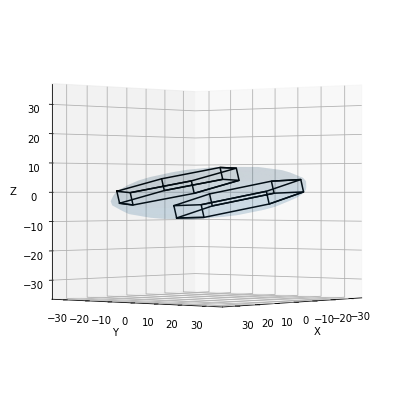

w


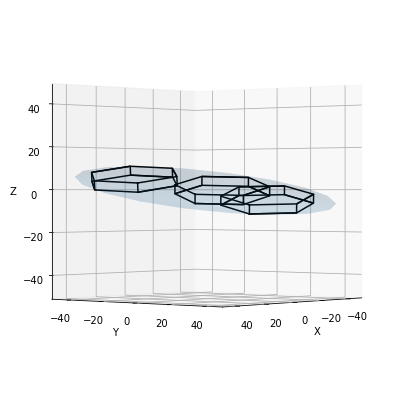

w


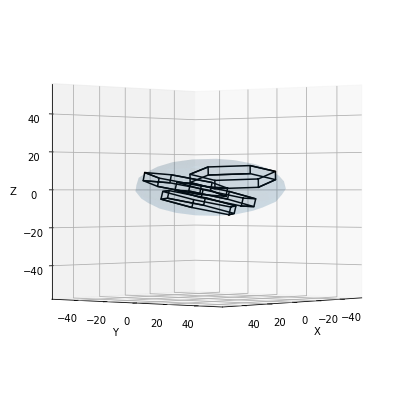

w


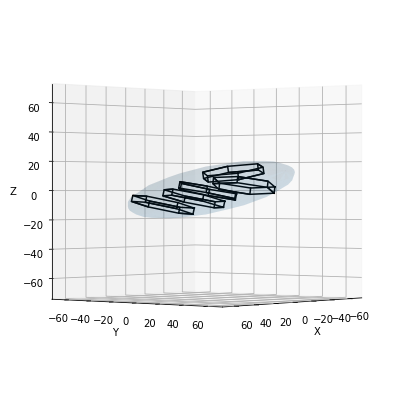

w


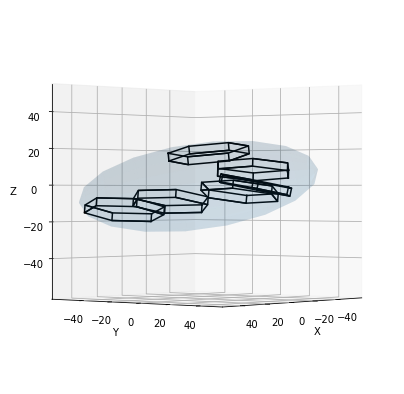

w


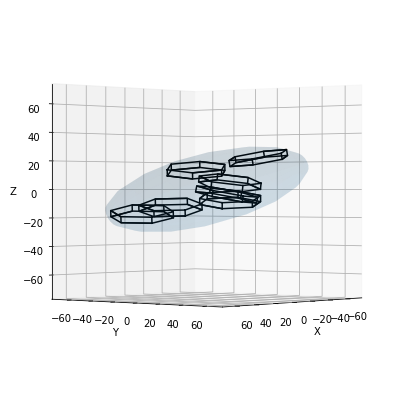

w


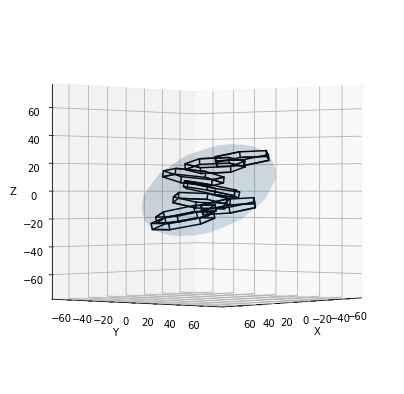

w


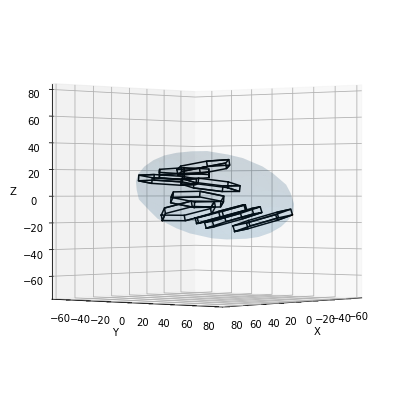

w


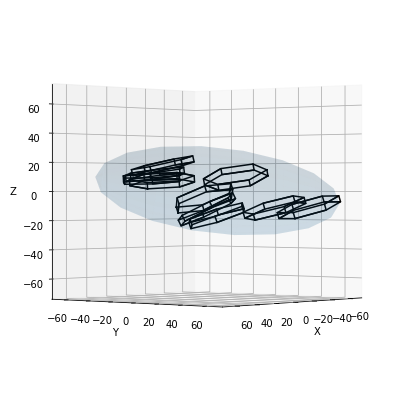

w


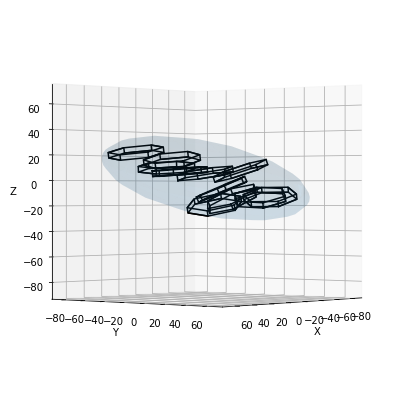

w


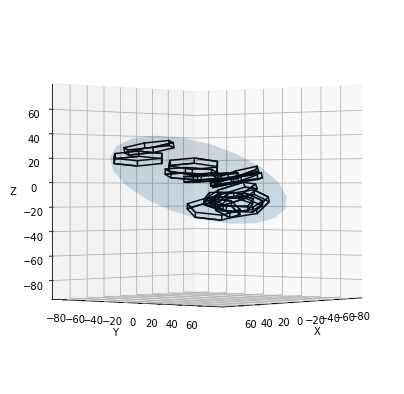

w


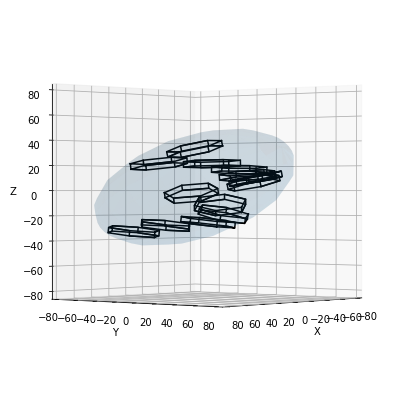

w


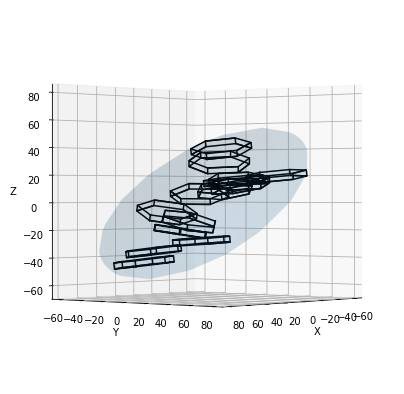

w


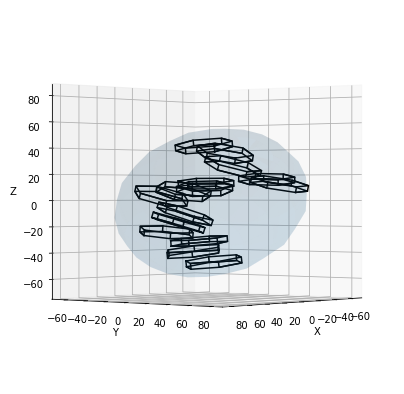

w


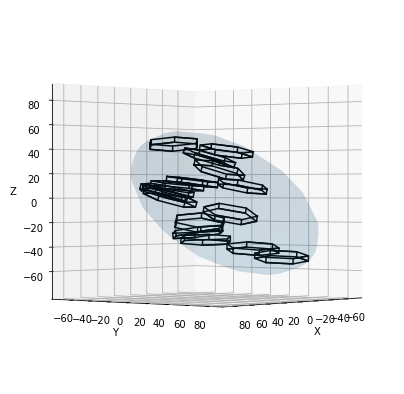

w


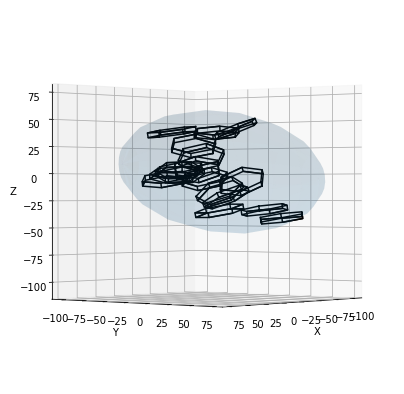

w


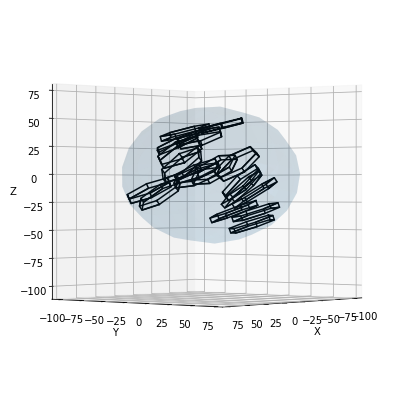

w


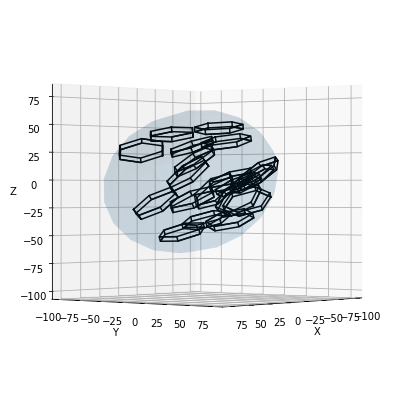

w


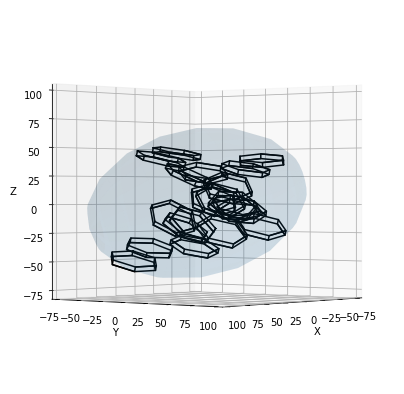

w


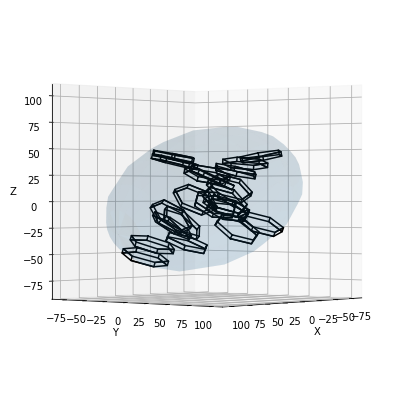

w


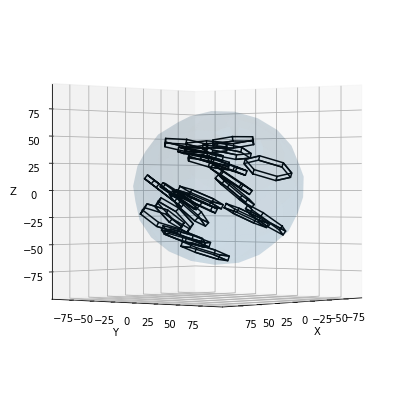

w


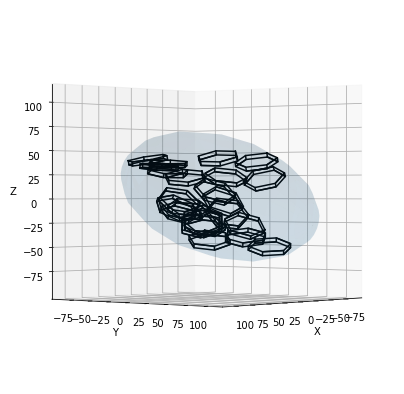

w


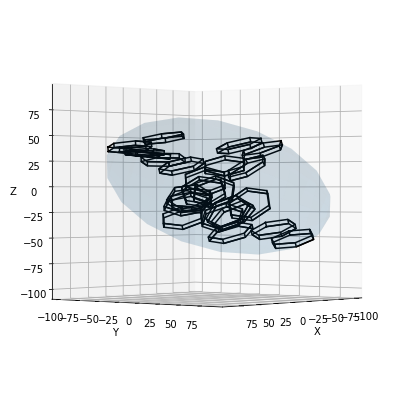

w


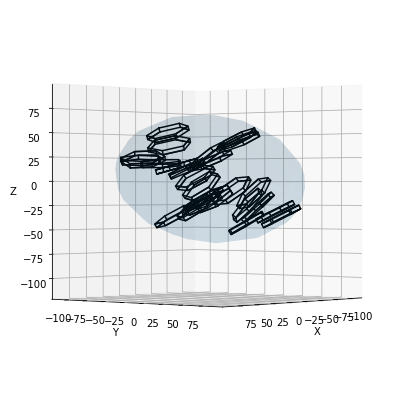

w


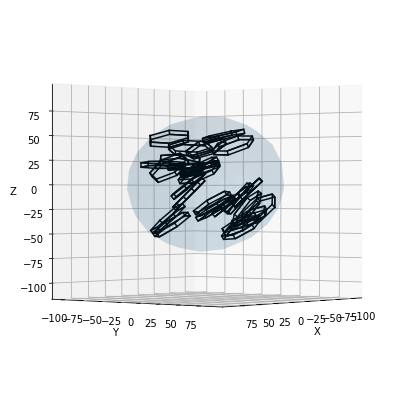

w


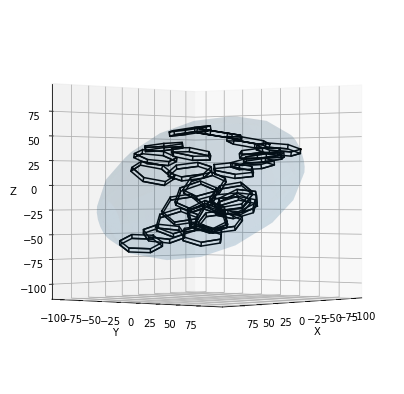

w


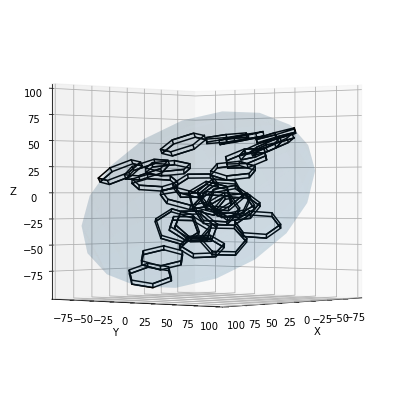

w


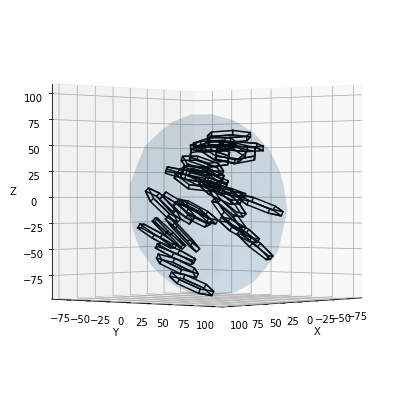

w


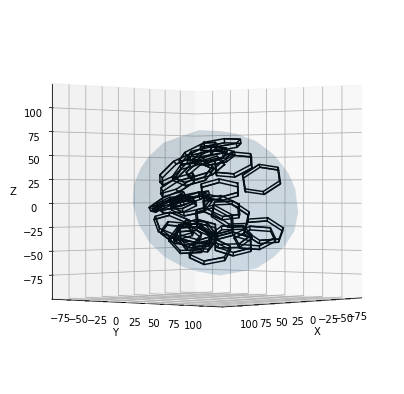

w


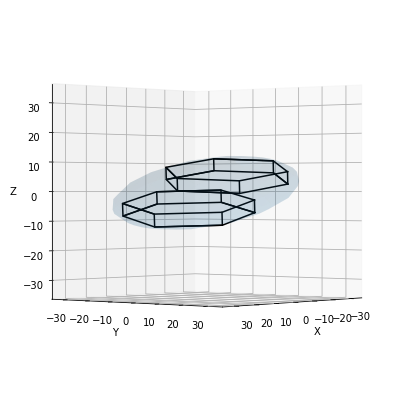

w


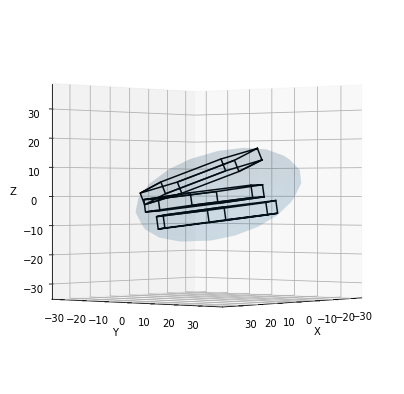

w


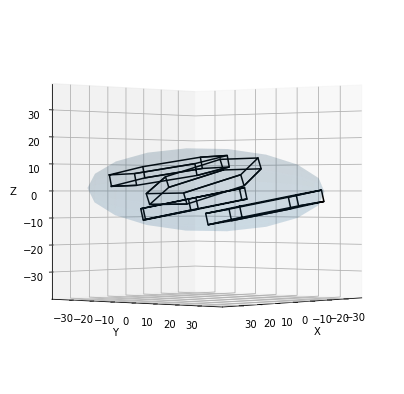

w


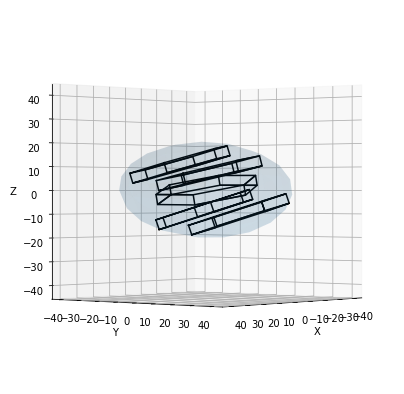

w


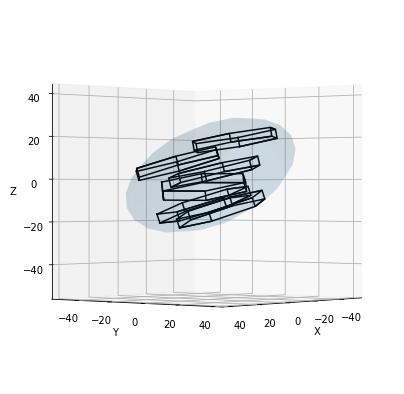

w


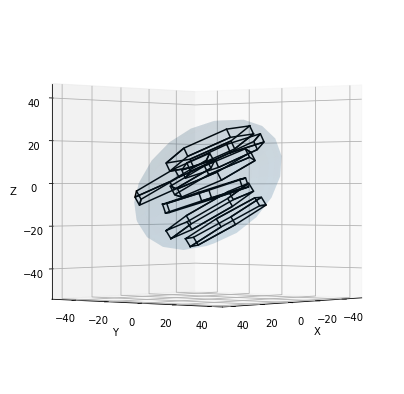

w


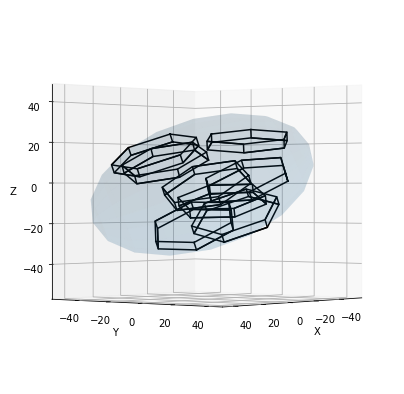

w


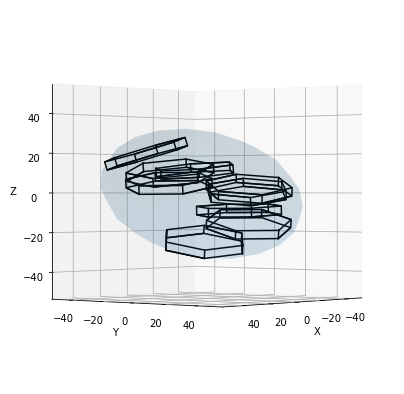

w


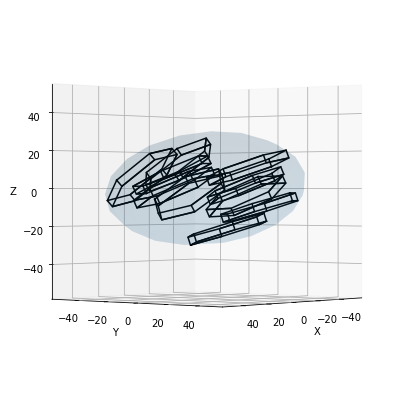

w


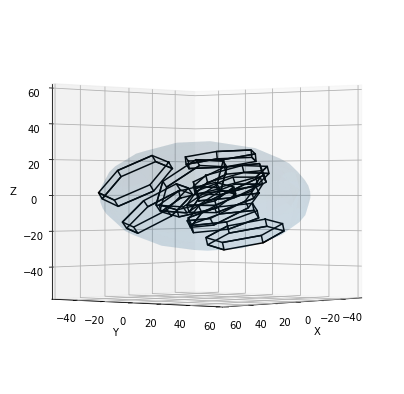

w


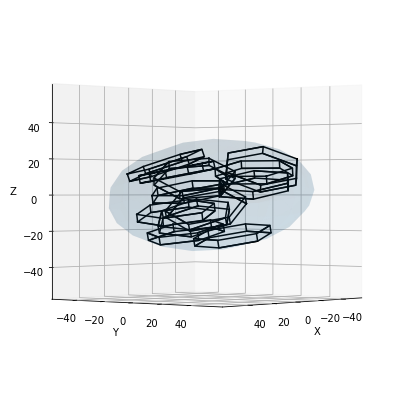

w


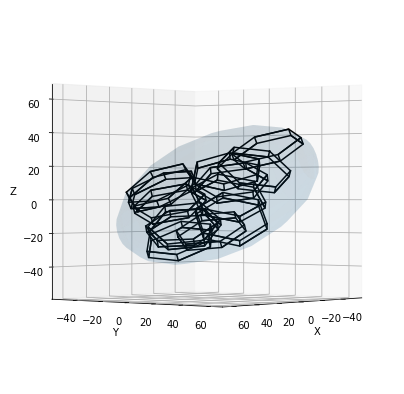

w


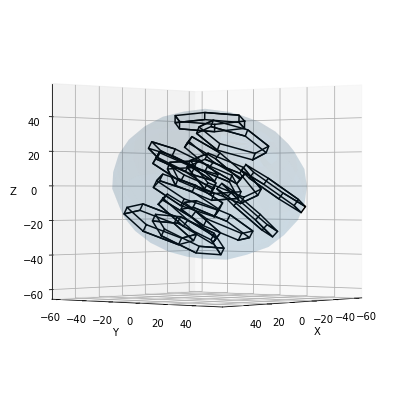

w


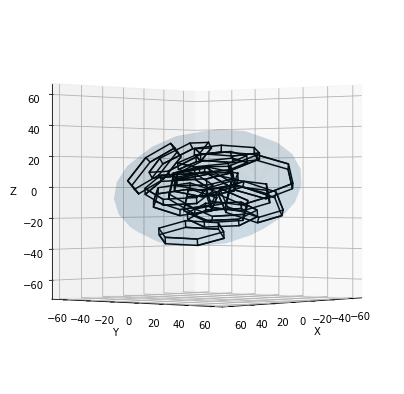

w


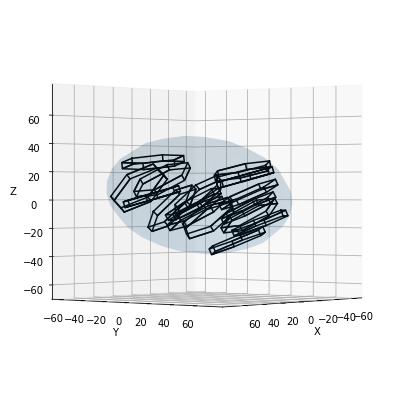

w


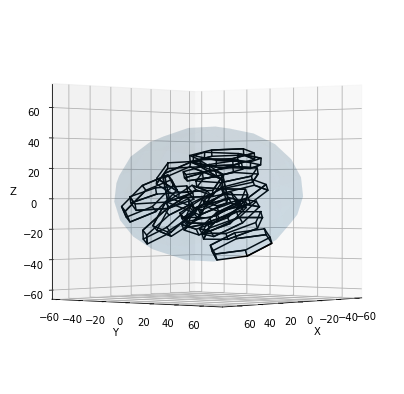

w


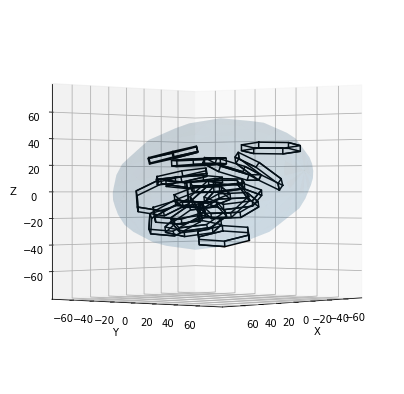

w


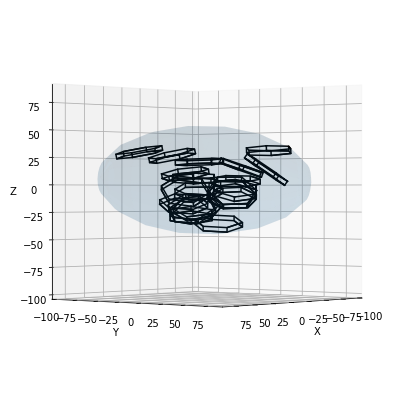

w


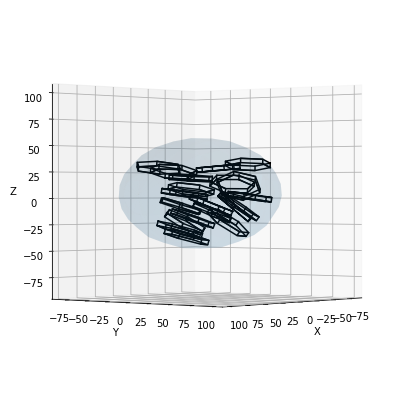

w


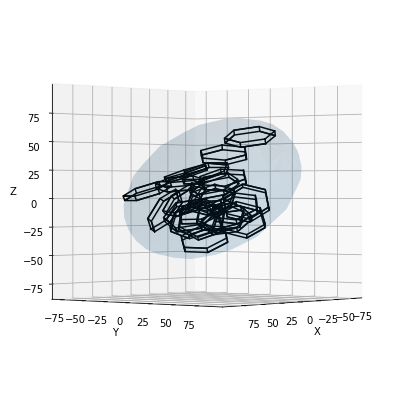

w


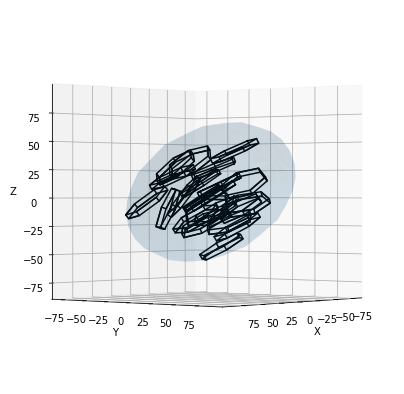

w


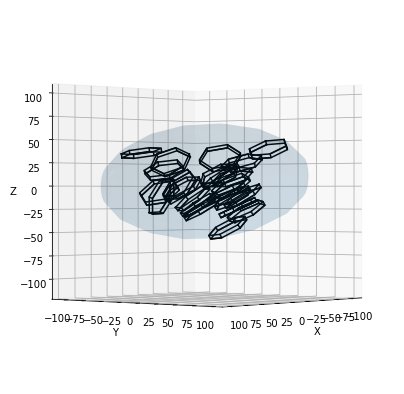

w


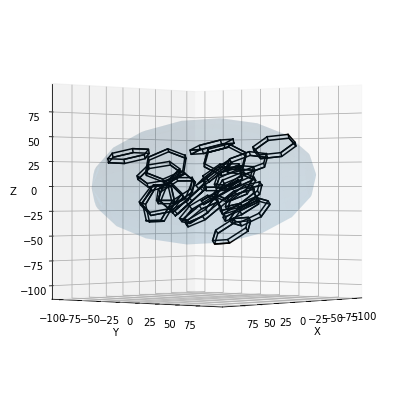

w


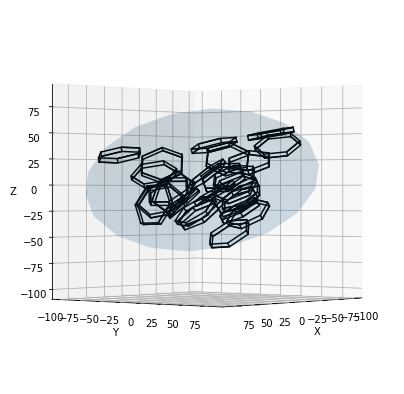

w


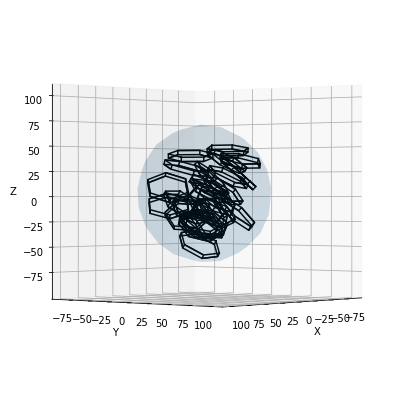

w


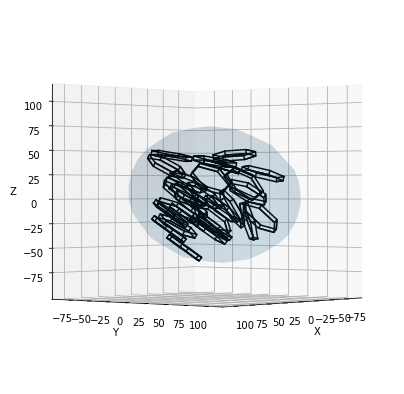

w


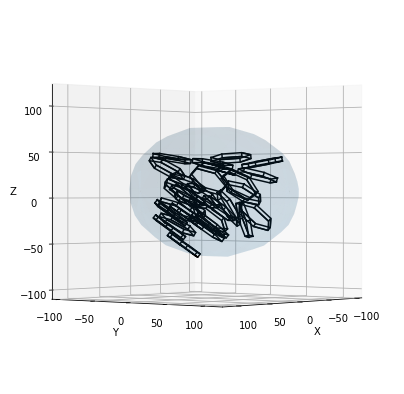

w


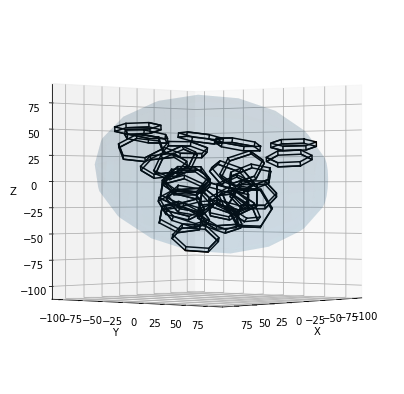

w


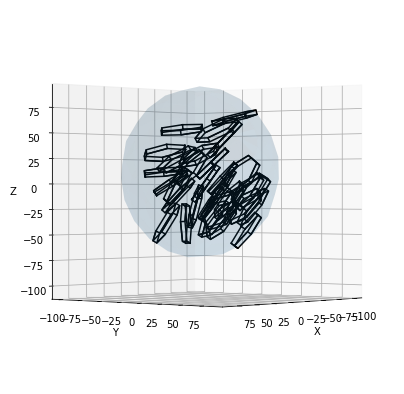

nclus 10 0.1 2
w


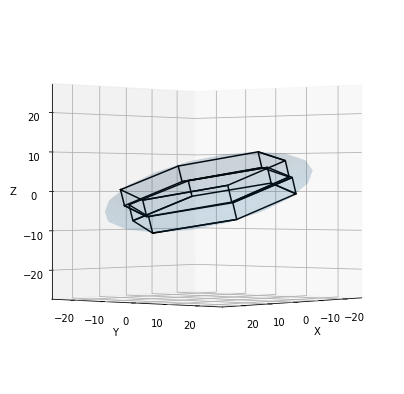

w


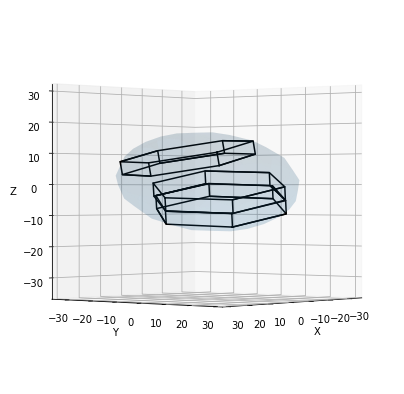

w


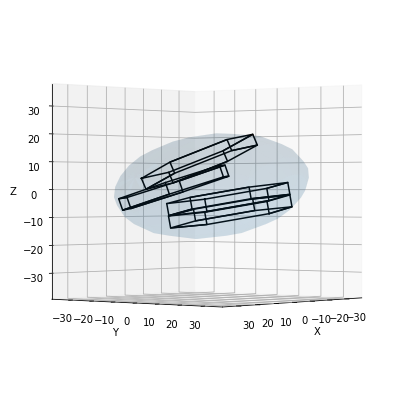

w


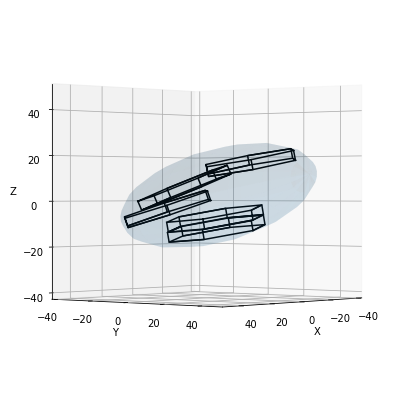

w


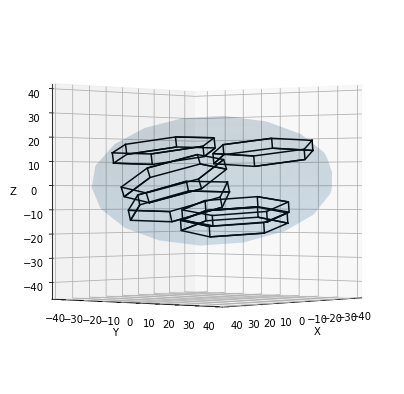

w


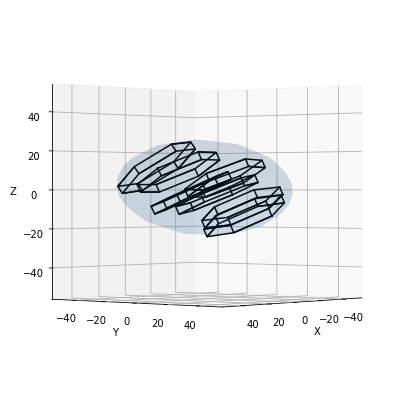

w


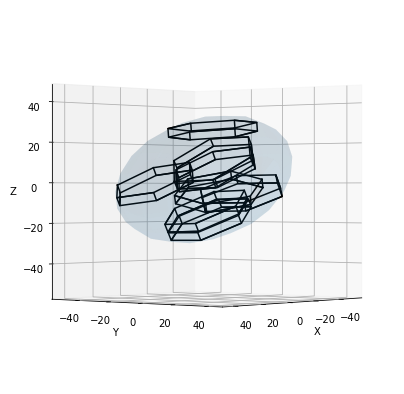

w


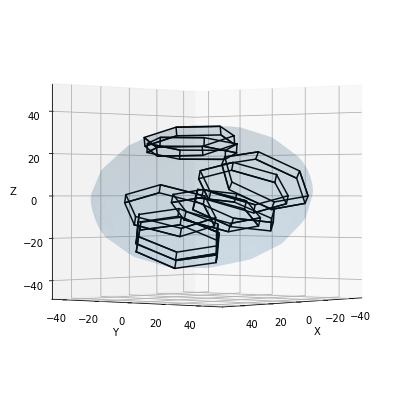

w


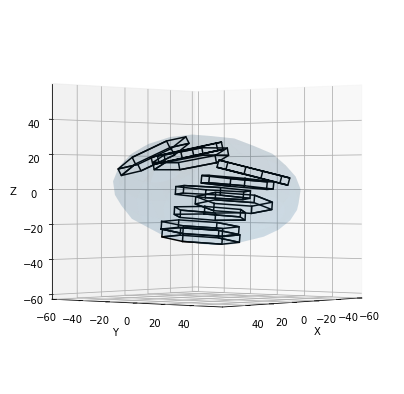

w


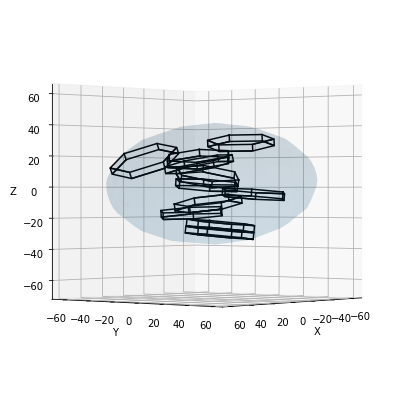

w


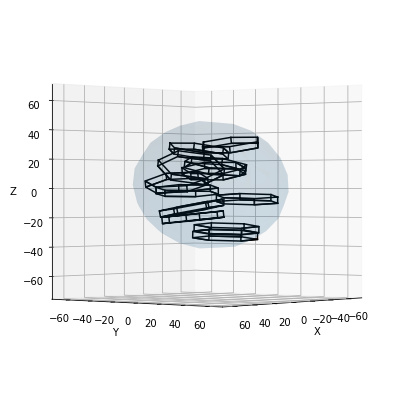

w


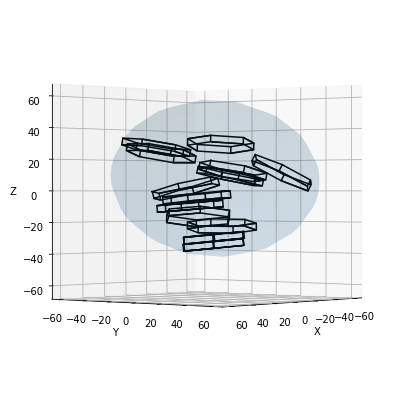

w


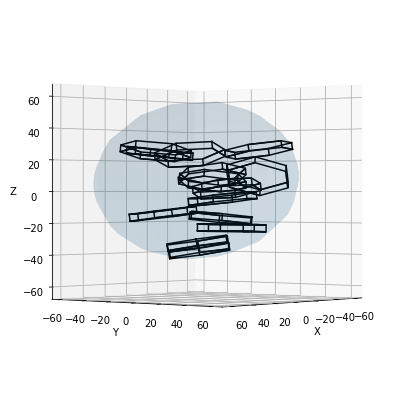

w


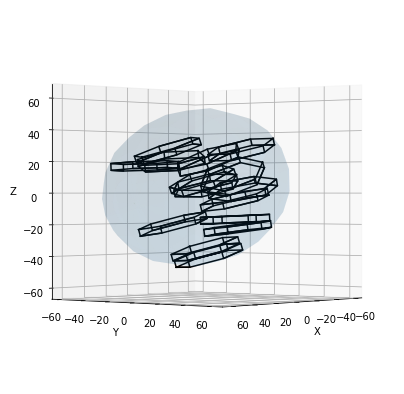

w


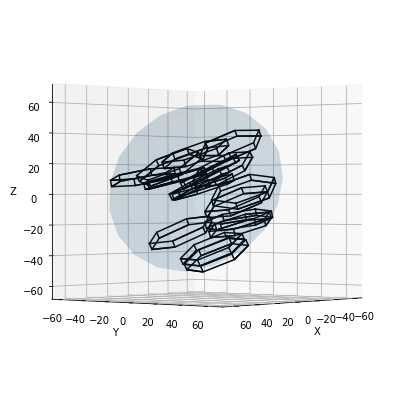

w


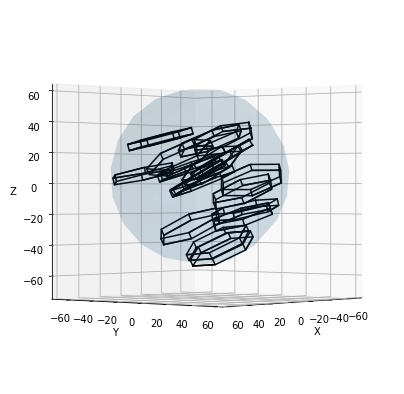

w


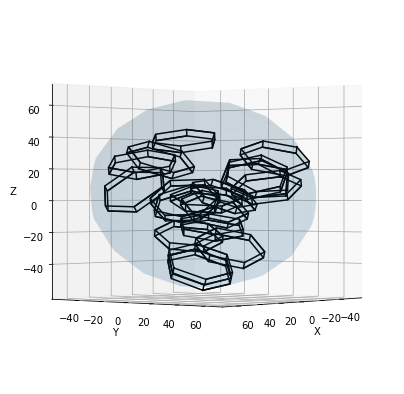

w


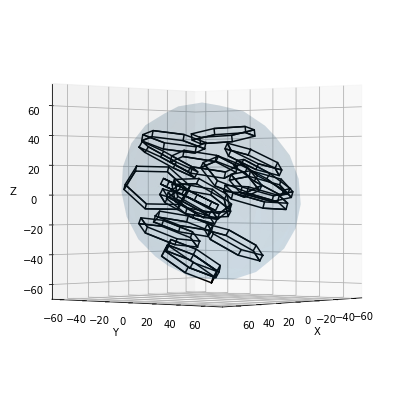

w


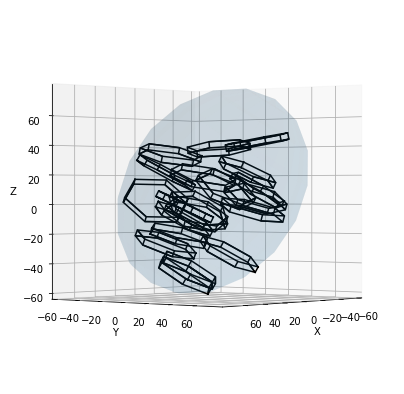

w


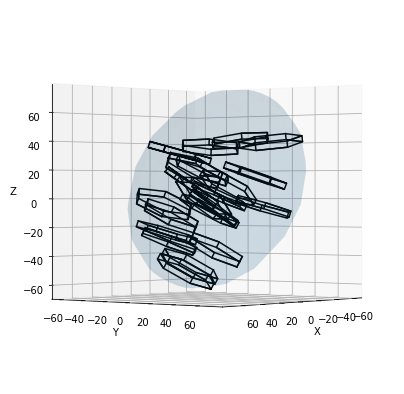

w


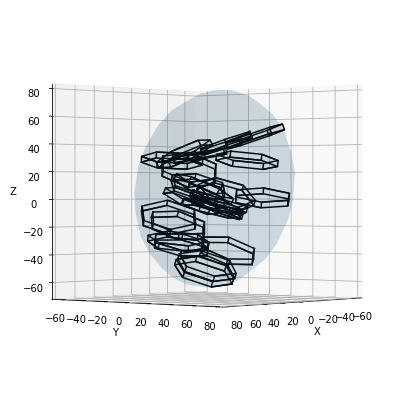

w


KeyboardInterrupt: 

In [9]:
if __name__ == '__main__':
    phioarr=np.logspace(-1, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    print(phioarr)
    reqarr = [10,20,30,40,50]
    nclusters = 3         #changes how many aggregates per aspect ratio to consider
    ncrystals = 30
    rand_orient = False    #randomly orient the seed crystal and new crystal: uses first random orientation
  
    output = main()


In [ ]:
dd = defaultdict(list)
for d in output:
    for key, value in d.items():
        for val in value:
            dd[key].append(val)
    

In [ ]:
%%timeit
filename = '../instance_files/createdb_iceagg_rand_r500_1000'
filehandler = open(filename, 'wb')
pickle.dump(dd, filehandler)
filehandler.close()

In [50]:
# Dump to file
hkl.dump(dd, '../instance_files/createdb_iceagg_rand_r80_400.hkl', mode='w')

# Dump data, with compression
hkl.dump(dd, '../instance_files/createdb_iceagg_rand_r80_400_gzip.hkl', mode='w', compression='gzip')

# Compare filesizes
print('uncompressed: %i bytes' % os.path.getsize('../instance_files/createdb_iceagg_rand_r80_400.hkl'))
print('compressed:   %i bytes' % os.path.getsize('../instance_files/createdb_iceagg_rand_r80_400_gzip.hkl'))


uncompressed: 60201234 bytes
compressed:   60201234 bytes


In [53]:
dd_hkl = hkl.load('../instance_files/createdb_iceagg_rand_r80_400.hkl')

UnpicklingError: pickle data was truncated

In [48]:
file = open('../instance_files/createdb_iceagg_rand_r1_5', 'rb')
dd = pickle.load(file)


In [ ]:
with open('../instance_files/instance_iceice_flat_rall', "ab") as f:
    for data in agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds:
        pickle.dump(data, f)

In [ ]:
d['points'] = pickle.dumps(d['points'], protocol=2)

In [5]:
points = pickle.dumps(dd['points'], protocol=2)

In [11]:
df = pd.DataFrame(dd)

In [7]:
d = pd.concat([
    df[['mono_phi', 'mono_r','ncrystals', 'a', 'b', 'c', 'cplx', 'phi2D']],
    pd.DataFrame(df['points'])], axis=1)

In [25]:
from pymongo import MongoClient 
import pymongo
from bson.binary import Binary

In [40]:
from itertools import islice

def chunks(data, SIZE=100):
    it = iter(data)
    for i in range(0, len(data), SIZE):
        yield {k:data[k] for k in islice(it, SIZE)}
split = chunks(d)


In [35]:
len(d['a'])

696000

In [41]:
client = MongoClient(
    'app-01.arcc.albany.edu',
    27000,
    username='vprzybylo',
    password='84!LIxME'
)
db=client['asrc']

In [42]:
aggregates = db[ "aggregates" ]
result=aggregates.insert_many(split)

DocumentTooLarge: BSON document too large (82631233 bytes) - the connected server supports BSON document sizes up to 16777216 bytes.

In [ ]:
%%time 
engine = create_engine('sqlite:///../db_files_round2/createdb_iceagg_rand_r1_4.sqlite')#fast_executemany=True
df = pd.DataFrame.from_dict(dd)
df.to_sql('aggregates', con=engine, if_exists='replace', method='multi',\
          dtype={"ncrytals": sqlalchemy.types.INTEGER(),
                      "points": sqlalchemy.types.PickleType,
                      "a": sqlalchemy.types.Float(precision=6, asdecimal=True),
                      "b": sqlalchemy.types.Float(precision=6, asdecimal=True),
                      "c": sqlalchemy.types.Float(precision=6, asdecimal=True), 
                      "cplx": sqlalchemy.types.Float(precision=6, asdecimal=True),
                      "phi2D": sqlalchemy.types.Float(precision=6, asdecimal=True),
                      "mono_phi": sqlalchemy.types.Float(precision=6, asdecimal=True),
                      "mono_r": sqlalchemy.types.INTEGER()})

In [7]:
df = pd.read_sql_table(table_name='aggregates', con='sqlite:///test.sqlite', index_col='mono_phi')

In [497]:
def closest_points(cluster, cluster2):

    minclus2 = np.amin(cluster2.points['z'])
    maxclus1 = np.amax(cluster.points['z'])

    if minclus2 < maxclus1:
        diffmins = maxclus1 - minclus2
        cluster2.move([0, 0, diffmins])

    try:
        nearest_geoms_xz = nearest_points(cluster.projectxz(), cluster2.projectxz())
        nearest_geoms_yz = nearest_points(cluster.projectyz(), cluster2.projectyz())
        nearest_geoms_xy = nearest_points(cluster.projectxy(), cluster2.projectxy())
        #print('z from yz', nearest_geoms_yz[0].x, nearest_geoms_yz[0].y)
              
    except ValueError:
        return (None, None)
    
#     cluster.add_crystal(cluster2)
# #     cluster.plot_ellipsoid_aggs([cluster], nearest_geoms_xz=nearest_geoms_xz, nearest_geoms_yz=nearest_geoms_yz,\
# #                                 nearest_geoms_xy=nearest_geoms_xy, view='x', circle=None)
#     cluster.plot_ellipsoid_aggs([cluster], nearest_geoms_xz=nearest_geoms_xz, nearest_geoms_yz=nearest_geoms_yz,\
#                                 nearest_geoms_xy=nearest_geoms_xy, view='y', circle=None)

#     cluster.remove_crystal(cluster2)
    
    agg_yz = np.array([nearest_geoms_yz[0].x, nearest_geoms_yz[0].y]) #agg
    xtal_yz = np.array([nearest_geoms_yz[1].x, nearest_geoms_yz[1].y]) #crystal2

    stacked = np.array([cluster.points['y'].ravel(), cluster.points['z'].ravel()]).T
    tree = spatial.cKDTree(stacked)  
    distance, index = tree.query([xtal_yz], n_jobs=-1)
    agg_xyz_closest = cluster.points.ravel()[index]
    
    move_y = xtal_yz[0]-agg_yz[0]
    movez_yz = xtal_yz[1]-agg_yz[1]    

    nearpt_xz = nearest_points(Point(agg_xyz_closest['x'],agg_xyz_closest['z']), cluster2.projectxz())
#     cluster.add_crystal(cluster2)
#     cluster.plot_ellipsoid_aggs([cluster], nearest_geoms_xz=nearest_geoms_xz, nearest_geoms_yz=nearest_geoms_yz,\
#                                 nearest_geoms_xy=nearest_geoms_xy, view='x', circle=None)

#     cluster.remove_crystal(cluster2)

    move_x = nearpt_xz[1].x-nearpt_xz[0].x
    movez_xz = nearpt_xz[1].y-nearpt_xz[0].y
    cluster2.move([-move_x, -move_y, -(max(abs(movez_xz), abs(movez_yz)))])
       

w


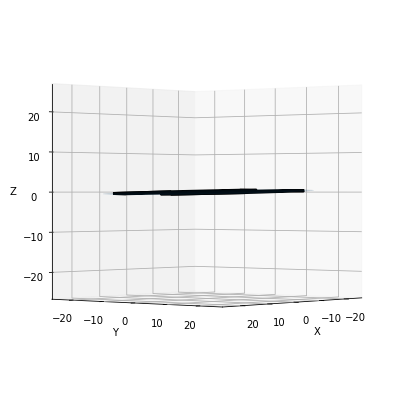

x


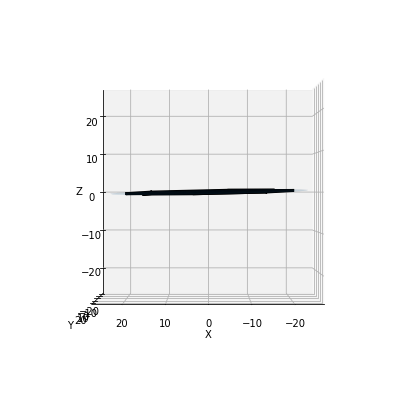

y


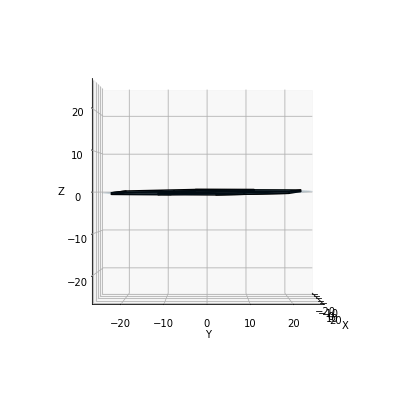

z


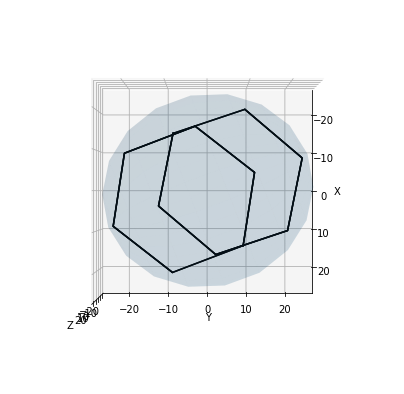

w


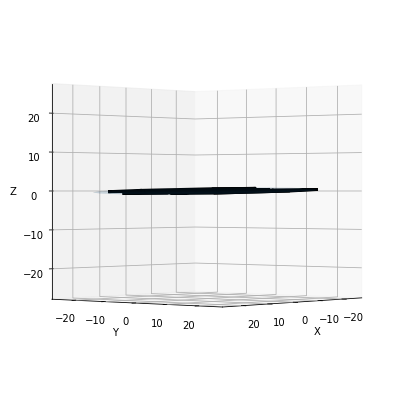

x


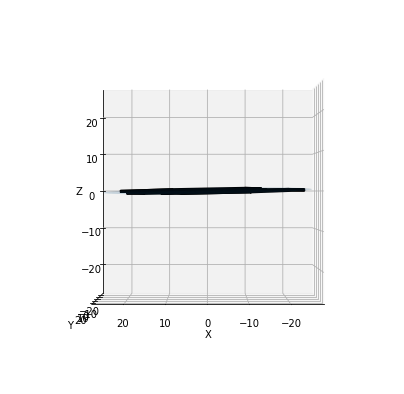

y


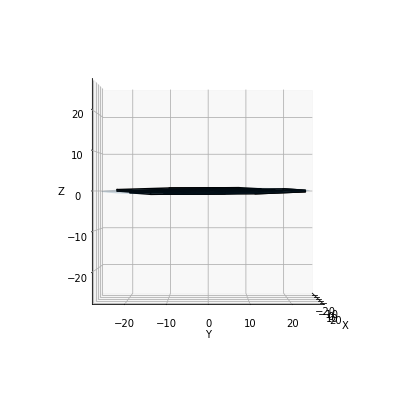

z


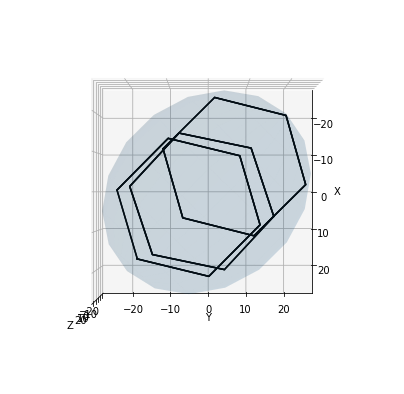

w


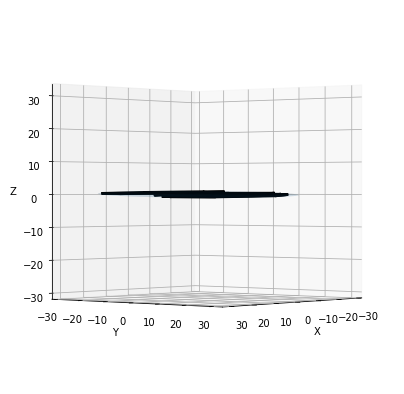

x


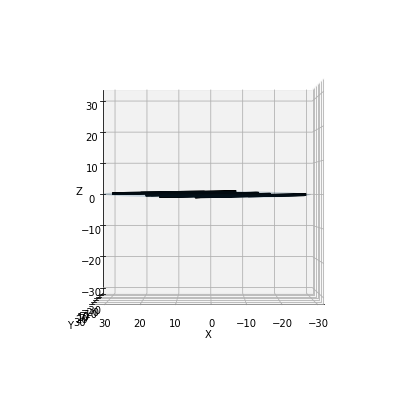

y


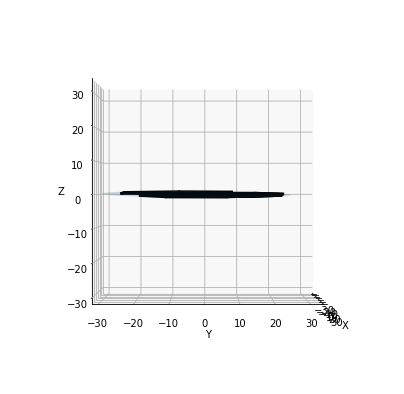

z


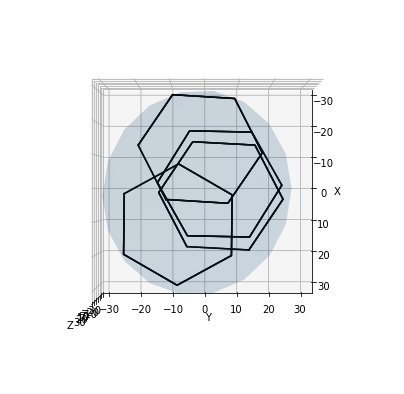

w


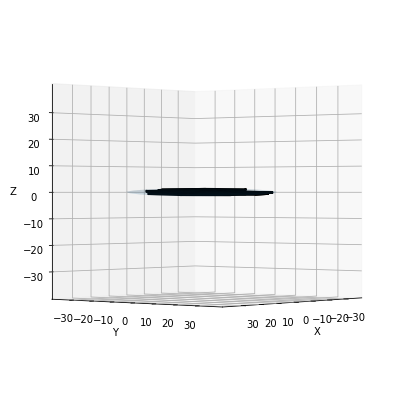

x


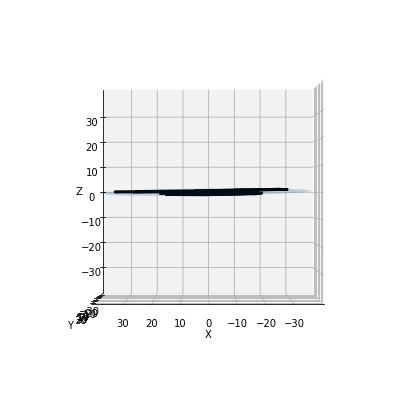

y


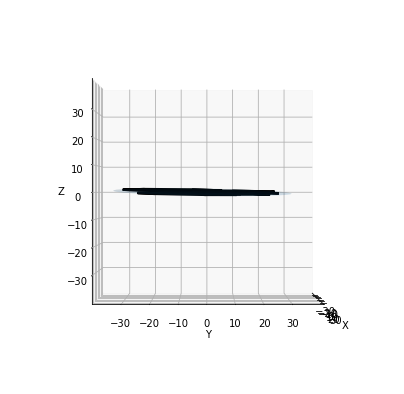

z


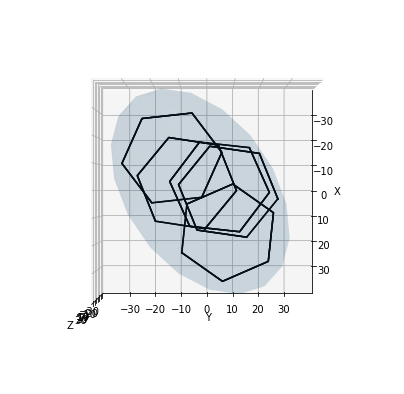

w


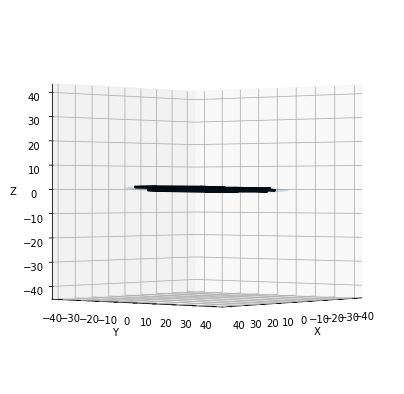

x


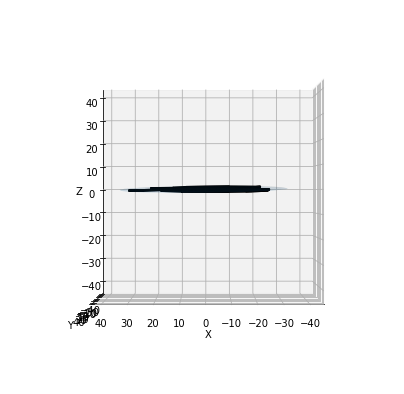

y


KeyboardInterrupt: 

In [527]:
phio = .010
r = 4
ncrystals = 15
rand_orient=False
a = (r ** 3 / phio) ** (1. / 3.)
c = phio * a

crystal1 = ipas.Ice_Crystal(c, a)
crystal1.hold_clus = crystal1.points
crystal1.orient_crystal(rand_orient)
crystal1.recenter()
cluster = ipas.Cluster_Calculations(crystal1)  #cluster will start with a random orientation if crystal was reoriented

while cluster.ncrystals < ncrystals: 

    crystal2 = ipas.Ice_Crystal(c,a)
    crystal2.hold_clus = crystal2.points
    crystal2.orient_crystal(rand_orient)
    crystal2.recenter()

    #start collection
    agg_pt, new_pt = cluster.generate_random_point_fast(crystal2, 1)
    movediffx = new_pt.x - agg_pt.x
    movediffy = new_pt.y - agg_pt.y
    crystal2.move([-movediffx, -movediffy, 0])

    closest_points(cluster, crystal2)

    cluster.add_crystal(crystal2)
    cluster.add_points = cp.deepcopy(cluster.points)

    if a>c and rand_orient== False:
        cluster.orient_cluster() 
    else:
        cluster.orient_cluster(rand_orient) 
    cluster.recenter()
    cluster.orient_points = cp.deepcopy(cluster.points)

    print('w')
    cluster.plot_ellipsoid_aggs([cluster], view='w', circle=None)
    print('x')
    cluster.plot_ellipsoid_aggs([cluster], view='x', circle=None)
    print('y')
    cluster.plot_ellipsoid_aggs([cluster], view='y', circle=None)
    print('z')
    cluster.plot_ellipsoid_aggs([cluster], view='z', circle=None)